#SETUP

## **Installation**
First we need to install the package. Feel free to copy the terminal command for local installation.

In [1]:
!pip3 install --force-reinstall scrambledConvolution@git+https://github.com/tillvogt/scrambledConvolution.git

  Cloning https://github.com/tillvogt/scrambledConvolution.git to /tmp/pip-install-psgdsan9/scrambledconvolution_e3311895f9cf439c9785e915b7deac25
  Running command git clone --filter=blob:none --quiet https://github.com/tillvogt/scrambledConvolution.git /tmp/pip-install-psgdsan9/scrambledconvolution_e3311895f9cf439c9785e915b7deac25
  Resolved https://github.com/tillvogt/scrambledConvolution.git to commit 672439259677a14c315f4c825d625813def4a855
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 12.5 MB/s eta 0:00:00
  Created wheel for scrambledConvolution: filename=scrambledconvolution-0.0.1-py3-none-any.whl size=306287 sha256=81d3943b70db189a1ae32f44526d316291af970609123dfa122a93bac933e

##**Imports**
next to the scrambledConvolution package, numpy and numba are installed as dependencies.
For visualizing things we import matplotlib.pyplot.

The scrambledConvolution Package can be divided in different Subpackages:


*   .layers: the different processinglayers like *'Convolutional'*, *'Dense'*, *'Pooling'* and *'Reshape'*.
*   .activations: the different activation Layers like *'Softmax'*, *'Sigmoid'*, *'Tanh'*
*   .losses: Lossfunctions like *'RMS'* and *'binary_cross_entropy'*
*   .datasets: small sample packages like a shrinked version of MNIST





In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scrambledConvolution.layers import Convolutional
from scrambledConvolution.datasets.mnist_loader import load_data

Sie nutzen das sehr gute Package von Till Vogt


#CONVOLUTIONAL LAYER

##**Loading testdata**

Due to the fact, that this whole project is mainly about the Convolutional Layer, we try out some of the corresponding features.

So lets import some handwritten digits from MNIST Dataset. We use the build in Dataloader for that.

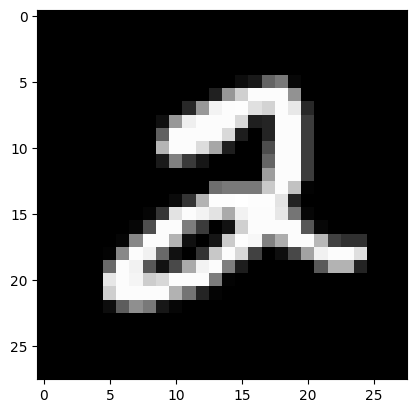

In [3]:
x_train, y_train, x_test, y_test = load_data()

#change the picture_index for choosing another example
picture_index = 5
test_image = x_train[picture_index]

plt.imshow(test_image[0], cmap="gray")

##**Using 'Convolution'**

Now we instantiate a Convolutional layer. For feeding it with our testdata, just give it as argument, for the *.forward* method.

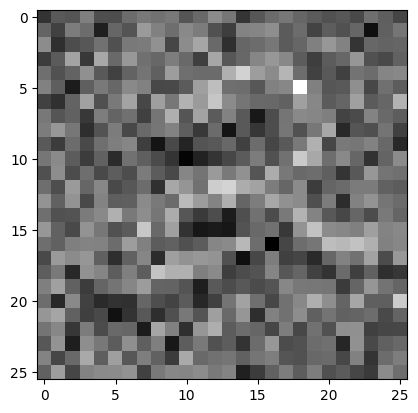

In [4]:
conv1 = Convolutional((1,28,28), 3, 1, type="regular", mix_factor = 0)
conv_image = conv1.forward(test_image)

plt.imshow(conv_image[0], cmap="gray")

As you might see, the image is reduced in size, as well as noisy. The noise comes from the randomly picked biases, when initialising the Layer. So for investigate the kernel variations, we should set them to zero:

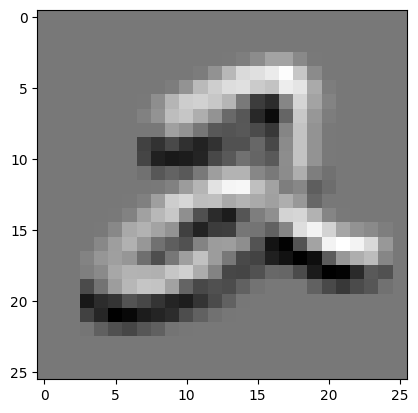

In [5]:
conv1.biases = np.zeros(conv1.biases.shape)
conv_image = conv1.forward(test_image)

plt.imshow(conv_image[0], cmap="gray")

##Mix IT UP!##

Now after removing noise, let's test the mixing capabilities.
Here you can pick one of the different types:
*   "*regular*" = standard cross-correlation
*   "*retinaMix*" = the kernel stays in square shape, directs the result of operations to random positions in the resulting image
*   "*kernelMix*" = in this mode, the kernel is variated. For some of the Operations pixel inside the kernel is redirected to a random position.


All the mixing operations depend on the *mix_factor*, wich is a frequency depending on the imagesize.

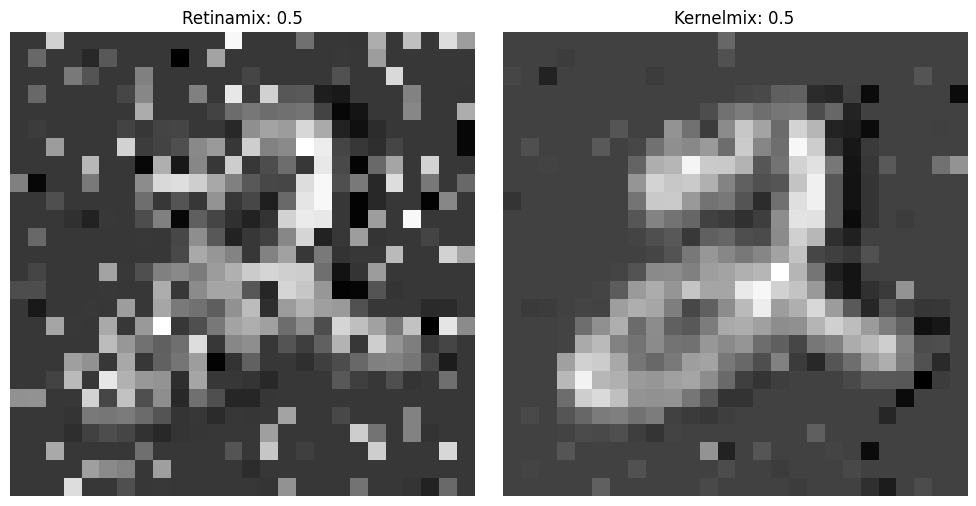

In [6]:
#Instantiate two Concolutional layers
conv_retina_mix = Convolutional((1,28,28), 3, 1, type="retinaMix", mix_factor=0.5)
conv_kernel_mix = Convolutional((1,28,28), 3, 1, type="kernelMix", mix_factor=0.5)

#Setting same weights for better comparison
conv_retina_mix.kernels = conv_kernel_mix.kernels

#Setting biases to zero
conv_retina_mix.biases = np.zeros(conv_retina_mix.biases.shape)
conv_kernel_mix.biases = np.zeros(conv_kernel_mix.biases.shape)

#feeding it with the testimage
retina_mix_image = conv_retina_mix.forward(test_image)
kernel_mix_image = conv_kernel_mix.forward(test_image)


######plotting#####
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(retina_mix_image[0], cmap="gray")
axs[0].title.set_text("Retinamix: 0.5")
axs[0].axis("off")

axs[1].imshow(kernel_mix_image[0], cmap="gray")
axs[1].title.set_text("Kernelmix: 0.5")
axs[1].axis("off")

plt.tight_layout()
plt.show()

#TRAIN

##Essential imports

For training a Network, one has to make some further imports first.

In [7]:
from scrambledConvolution import train
from scrambledConvolution.losses import mse, mse_prime
from scrambledConvolution.activations import Sigmoid, Softmax
from scrambledConvolution.layers import *

##Building Network

Now we are able to build a Network as a list of the different layer Classes.

In [8]:
convolution_type = "kernelMix"
mix_factor = 0


network = [
      Convolutional((1, 28, 28), 5, 5, type=convolution_type, mix_factor=mix_factor),
      Sigmoid(),
      Pooling(),
      Convolutional((5, 12, 12), 5, 5, type=convolution_type, mix_factor=mix_factor),
      Sigmoid(),
      Pooling(),
      Reshape((5,4,4), ((5*4*4), 1)),
      Dense(80, 32),
      Sigmoid(),
      Dense(32,10),
      Softmax()
]

##Do you even lift?

Fortunatly the pc trains for us...

Just use the *train()* function and set the essential parameters. A fews things to explain:

*   *friction:* There is no real optimizier implemented. However, to overcome saddle points 'inertia' is implemented. the *friction* parameter is the factor of the previous gradient. I recomment a value between 0 (no inertia) to 1.
*   *weight-saving:* If this is TRUE, the weights and biases of convolutional Layers are saved in a .csv at the end of the training

In [9]:
_ = train(mix_factor, network, mse, mse_prime, x_train, y_train, x_test, y_test, epochs = 10, batch_size = 16, )

0.00, 1/10, train_error=0.1045, test_error=0.1040, accuracy=11%
0.00, 2/10, train_error=0.0998, test_error=0.1015, accuracy=10%
0.00, 3/10, train_error=0.0982, test_error=0.1005, accuracy=11%
0.00, 4/10, train_error=0.0972, test_error=0.0999, accuracy=11%
0.00, 5/10, train_error=0.0964, test_error=0.0995, accuracy=10%
0.00, 6/10, train_error=0.0959, test_error=0.0992, accuracy=11%
0.00, 7/10, train_error=0.0955, test_error=0.0990, accuracy=14%
0.00, 8/10, train_error=0.0952, test_error=0.0987, accuracy=15%
0.00, 9/10, train_error=0.0948, test_error=0.0985, accuracy=17%
0.00, 10/10, train_error=0.0945, test_error=0.0981, accuracy=18%
Time taken: 135.95309834500003
